# 图像相关层
conv和pool，包含1维，2维和3维。池化又分为平均值池化、最大值池化、自适应池化等。卷积还有逆卷积（TransposeConv）

## 卷积层

In [1]:
from PIL import Image
from torchvision.transforms import ToPILImage, ToTensor
import torch.nn as nn
import torch

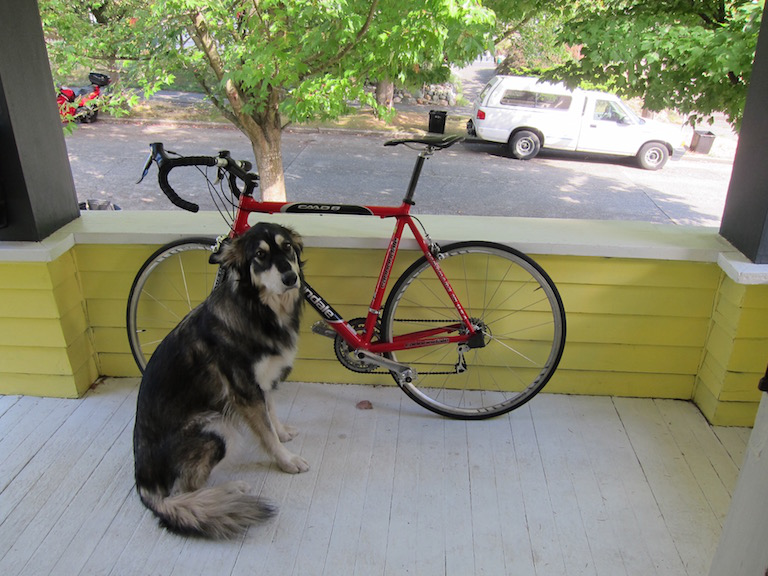

In [2]:
to_tensor = ToTensor()
to_pil = ToPILImage()
dog = Image.open("dog.jpg")
dog

nn.Conv2d(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True))

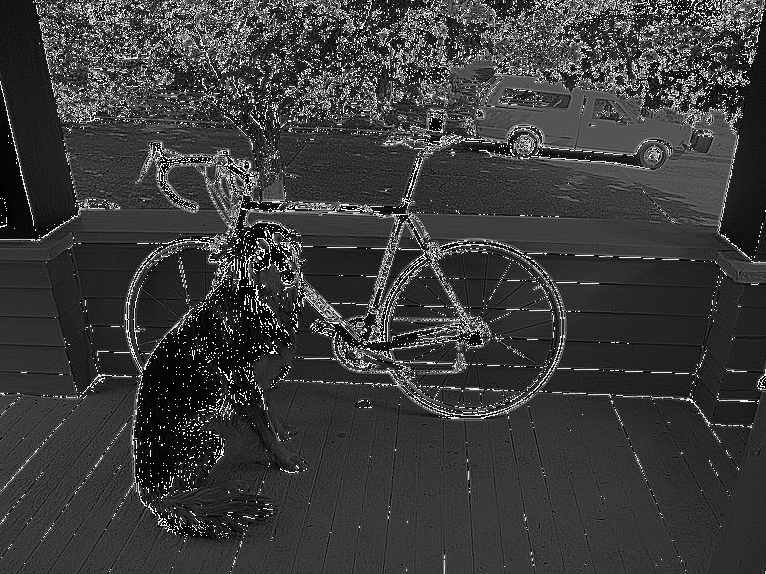

In [3]:
inputs = to_tensor(dog).unsqueeze(0) #必须为4维，包含batch_size

#卷积核
kernel = torch.ones(3, 3)/-9.0
kernel[1, 1] = 1
conv = nn.Conv2d(3, 3, (3,3), bias = False)
conv.weight.data = kernel.expand(3,3,3,3) #给权重赋值

out = conv(inputs)
to_pil(out.squeeze())

## 池化层

In [4]:
pool = nn.AvgPool2d(2,2)
list(pool.parameters())

[]

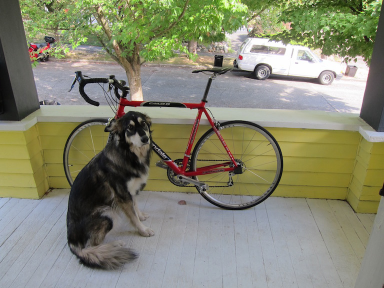

In [5]:
out = pool(inputs)
to_pil(out.squeeze())

## 其他层
Linear:全连接层

BatchNorm:分1D，2D，3D。除了标准的BN，还有在风格迁移中常用的InstanceNorm

Dropout:分1D，2D，3D

In [6]:
inputs = torch.randn((2,3), requires_grad = True)
liner = nn.Linear(3, 4)
h = liner(inputs) #[2, 4]
h

tensor([[ 0.5082,  0.4662,  1.0761, -0.0087],
        [-0.0177, -0.1082,  0.0322, -0.2838]], grad_fn=<AddmmBackward>)

In [7]:
bn = nn.BatchNorm1d(4)
#bn.weight.data = torch.ones(4) * 4
#bn.bias.data = torch.zeros(4)

bn_out = bn(h)

# 计算无偏方差时分母会-1， unbiased = False时则不会
bn_out.mean(0), bn_out.var(0, unbiased = False)

(tensor([ 0.0000e+00, -2.9802e-08,  5.9605e-08,  2.9802e-08],
        grad_fn=<MeanBackward1>),
 tensor([0.9999, 0.9999, 1.0000, 0.9995], grad_fn=<VarBackward1>))

In [8]:
dropout = nn.Dropout(0.5)
o = dropout(bn_out)
o

tensor([[ 0.0000,  0.0000,  2.0000,  1.9995],
        [-0.0000, -1.9999, -2.0000, -1.9995]], grad_fn=<MulBackward0>)

# 激活函数

In [11]:
relu = nn.ReLU(inplace=True) #直接将输出覆盖输入，节省内存；之所以可以覆盖是因为只需要根据输出便可以计算梯度，sigmoid也可以；一般不使用
inputs = torch.randn(2,3)
print("inputs:\n", inputs)
output = relu(inputs)
print("outputs:\n", output) #小于0的都为0
id(inputs) == id(output)

inputs:
 tensor([[0.6749, 1.0744, 1.4087],
        [1.2465, 0.1882, 0.8699]])
outputs:
 tensor([[0.6749, 1.0744, 1.4087],
        [1.2465, 0.1882, 0.8699]])


True

In [12]:
relu = nn.ReLU() 
inputs = torch.randn(2,3)
print("inputs:\n", inputs)
output = relu(inputs)
print("outputs:\n", output) #小于0的都为0
id(inputs) == id(output)

inputs:
 tensor([[ 0.3386,  3.0118, -0.1646],
        [ 0.9512, -0.5291, -0.4111]])
outputs:
 tensor([[0.3386, 3.0118, 0.0000],
        [0.9512, 0.0000, 0.0000]])


False

# ModuleList&Sequential

Sequential可以将输入一层接一层的传下去

In [18]:
# Sequential三种写法
net1 = nn.Sequential()
net1.add_module("conv", nn.Conv2d(3, 3, 3))
net1.add_module("batchnorm", nn.BatchNorm2d(3))
net1.add_module("activation_layer", nn.ReLU())

net2 = nn.Sequential(
        nn.Conv2d(3, 3, 3),
        nn.BatchNorm2d(3),
        nn.ReLU()
        )

from collections import OrderedDict #定义有序字典，普通的字典是无序的
net3 = nn.Sequential(
        OrderedDict([
        ('conv1', nn.Conv2d(3, 3, 3)), #注意这种字典的定义方法
        ('bn1', nn.BatchNorm2d(3)),
        ('relu1', nn.ReLU())
        ]))

In [21]:
print("net1:", net1)
print("net2:", net2)
print("net3:", net3)

net1: Sequential(
  (conv): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_layer): ReLU()
)
net2: Sequential(
  (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)
net3: Sequential(
  (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
)


In [22]:
#根据名字或者序号取出子module
net1.conv, net2[1], net3.relu1

(Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1)),
 BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU())

nn.ModuleList:以列表的形式包含各个子模块，并可以被自动识别为子module
list：使用list时，不能被自动识别为子module

In [23]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.list = [nn.Linear(3,4), nn.ReLU]
        self.module_list = nn.ModuleList([nn.Conv2d(3, 3, 3), nn.ReLU()])
    def forward(self):
        pass

In [24]:
model = MyModule()
model

MyModule(
  (module_list): ModuleList(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
)

In [27]:
for name, param in model.named_parameters():
    print(name, param.shape)

module_list.0.weight torch.Size([3, 3, 3, 3])
module_list.0.bias torch.Size([3])


ParameterList:可以包含多个parameter的类list对象，其中的parameter可训练。